In [1]:
import decoupler as dc
import matplotlib.pyplot as plt
# Only needed for processing
import numpy as np
import seaborn as sns 
import pandas as pd
import mygene
import os

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
# Set random seed so this part is reproducible
# https://www.random.org/ 2023-08-09
np.random.seed(3866)

In [3]:
tpm = pd.read_csv("../../../../data/expression/processed/train//V4//IO-Atlas-NSCLC-TPM-TRAIN-2023-08-10-V4.tsv", 
                  sep='\t', 
                  index_col=0)

universe = list(set(tpm.index.values))

In [4]:
msigdb = dc.get_resource('MSigDB')
msigdb['collection'].unique()
gsdb = msigdb[msigdb["collection"].isin(["go_biological_process", "reactome_pathways", "kegg_pathways", "hallmark", 'biocarta_pathways', 'mirna_targets_legacy'])]
# Remove duplicated entries
gsdb = gsdb[~gsdb.duplicated(['geneset', 'genesymbol'])]

0.00B [00:00, ?B/s]

0.00B [00:00, ?B/s]

In [5]:
with pd.ExcelWriter('../../../../data/enrichment/tauX-subtype-enrichment.xlsx', engine="openpyxl") as writer:  

    results = {}
    mg = mygene.MyGeneInfo()
    for cluster in ["Cluster-0", "Cluster-1", "Cluster-2"]:

        results[cluster] = {}

        ratios = pd.read_csv(f"../../../../data/ratios/IO-Atlas-NSCLC-NSCLC-Response-{cluster}-TPM-MinMaxNorm-TRAIN-2023-08-10-V4-ratios.tsv",
                             sep='\t', 
                             index_col=0)

        ratios["numerator"] = [x.split(":::")[0] for x in ratios.index.values]
        ratios["denominator"] = [x.split(":::")[1] for x in ratios.index.values]

        genes = list(set(list(ratios["numerator"].values) + list(ratios["denominator"].values)))

        res = mg.querymany(genes, scopes='ensembl.gene', fields='symbol', returnall=True)

        mapper = {}
        for q in res["out"]:
            if "symbol" in q:
                mapper[q["query"]] = q["symbol"]

        ratios["numerator_symbol"] = ratios["numerator"].map(mapper)
        ratios["denominator_symbol"] = ratios["denominator"].map(mapper)

        numerators = ratios[["cluster", "numerator_symbol"]].dropna().drop_duplicates(subset=["cluster", "numerator_symbol"])
        denominators = ratios[["cluster", "denominator_symbol"]].dropna().drop_duplicates(subset=["cluster", "denominator_symbol"])

        for ratio_cluster, rows in numerators.groupby("cluster"):

            results[cluster][ratio_cluster] = {}

            enr_pval = dc.get_ora_df(df=rows["numerator_symbol"].values,
                                     net=gsdb,
                                     source="geneset",
                                     target="genesymbol",
                                     n_background=len(universe))

            enr_pval = enr_pval.sort_values("p-value")

            results[cluster][ratio_cluster]["numerator"] = enr_pval.copy()

            print(enr_pval.head(10))
            
            enr_pval.to_excel(writer, sheet_name = f"{cluster} {ratio_cluster} numerator")


        for ratio_cluster, rows in denominators.groupby("cluster"):

            enr_pval = dc.get_ora_df(df=rows["denominator_symbol"].values,
                                    net=gsdb,
                                    source="geneset",
                                    target="genesymbol",
                                    n_background=len(universe))

            enr_pval = enr_pval.sort_values("p-value")

            print(enr_pval.head(10))

            results[cluster][ratio_cluster]["denominator"] = enr_pval.copy()
            
            enr_pval.to_excel(writer, sheet_name = f"{cluster} {ratio_cluster} denominator")

INFO:biothings.client:querying 1-680...
INFO:biothings.client:done.
INFO:biothings.client:Finished.


                                                  Term  Set size   
123        GOBP_IRON_ION_IMPORT_ACROSS_PLASMA_MEMBRANE         4  \
160  GOBP_NEGATIVE_REGULATION_OF_MONOATOMIC_ION_TRA...        92   
54                        GOBP_4FE_4S_CLUSTER_ASSEMBLY         5   
267  GOBP_REGULATION_OF_MITOCHONDRIAL_ELECTRON_TRAN...         5   
142  GOBP_NEGATIVE_REGULATION_OF_CALCIUM_ION_IMPORT...         5   
307                       GOBP_SOFT_PALATE_DEVELOPMENT         5   
261              GOBP_REGULATION_OF_IRON_ION_TRANSPORT         6   
214  GOBP_POSITIVE_REGULATION_OF_SYNAPTIC_VESICLE_E...         6   
170       GOBP_NEGATIVE_REGULATION_OF_T_CELL_MIGRATION         6   
107                    GOBP_HISTONE_LYSINE_METHYLATION       104   

     Overlap ratio   p-value  FDR p-value  Odds ratio  Combined score   
123       0.250000  0.005157     0.213631  263.510638     1388.016920  \
160       0.021739  0.006235     0.213631   22.209610      112.770963   
54        0.200000  0.006442    

/opt/conda/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


                                                   Term  Set size   
1385  GOBP_NEGATIVE_REGULATION_OF_CELL_PROLIFERATION...         4  \
3362                        HALLMARK_TGF_BETA_SIGNALING        54   
901                             GOBP_GOLGI_LOCALIZATION        14   
3080            GOBP_SMOOTH_MUSCLE_CELL_DIFFERENTIATION        61   
1839  GOBP_PLATELET_DERIVED_GROWTH_FACTOR_RECEPTOR_S...        55   
1431  GOBP_NEGATIVE_REGULATION_OF_GENE_EXPRESSION_EP...       105   
3272              GOBP_VENTRICULAR_SEPTUM_MORPHOGENESIS        42   
748   GOBP_ENDOPLASMIC_RETICULUM_TO_GOLGI_VESICLE_ME...       136   
3257  GOBP_VASCULAR_ASSOCIATED_SMOOTH_MUSCLE_CELL_MI...        26   
1668                            GOBP_NEURON_RECOGNITION        46   

      Overlap ratio   p-value  FDR p-value  Odds ratio  Combined score   
1385       0.750000  0.000031     0.125141   39.317460      408.342212  \
3362       0.129630  0.000093     0.178650    7.014184       65.123868   
901        0.28571

/opt/conda/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


Empty DataFrame
Columns: [Term, Set size, Overlap ratio, p-value, FDR p-value, Odds ratio, Combined score, Features]
Index: []


/opt/conda/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


                                                   Term  Set size   
3009                          HALLMARK_MTORC1_SIGNALING       200  \
1942                               GOBP_PROTEIN_FOLDING       222   
3021                 HALLMARK_UNFOLDED_PROTEIN_RESPONSE       113   
1943      GOBP_PROTEIN_FOLDING_IN_ENDOPLASMIC_RETICULUM        12   
3167  REACTOME_ATF6_ATF6_ALPHA_ACTIVATES_CHAPERONE_G...        10   
2604      GOBP_RESPONSE_TO_ENDOPLASMIC_RETICULUM_STRESS       256   
3166      REACTOME_ATF6_ATF6_ALPHA_ACTIVATES_CHAPERONES        12   
3010                            HALLMARK_MYC_TARGETS_V1       200   
2464              GOBP_REGULATION_OF_RESPONSE_TO_STRESS      1442   
470             GOBP_CHAPERONE_MEDIATED_PROTEIN_FOLDING        69   

      Overlap ratio       p-value   FDR p-value  Odds ratio  Combined score   
3009       0.100000  1.816221e-12  6.874397e-09    8.446765      228.352070  \
1942       0.081081  7.722059e-10  1.461400e-06    6.799645      142.668579   
302

/opt/conda/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")
INFO:biothings.client:querying 1-562...
INFO:biothings.client:done.
INFO:biothings.client:Finished.


                                                   Term  Set size   
2795               REACTOME_G1_S_DNA_DAMAGE_CHECKPOINTS        68  \
2491                               HALLMARK_E2F_TARGETS       200   
2796                          REACTOME_G2_M_CHECKPOINTS       150   
2899                  REACTOME_METABOLISM_OF_POLYAMINES        59   
3068  REACTOME_SCF_SKP2_MEDIATED_DEGRADATION_OF_P27_P21        60   
2644   REACTOME_ASYMMETRIC_LOCALIZATION_OF_PCP_PROTEINS        64   
3009                 REACTOME_REGULATION_OF_RAS_BY_GAPS        68   
2836                             REACTOME_HIV_INFECTION       231   
2696  REACTOME_CROSS_PRESENTATION_OF_SOLUBLE_EXOGENO...        50   
2669                    REACTOME_CELL_CYCLE_CHECKPOINTS       274   

      Overlap ratio       p-value  FDR p-value  Odds ratio  Combined score   
2795       0.132353  5.537358e-07     0.001470    9.894280      142.542719  \
2491       0.070000  1.300534e-06     0.001470    5.223322       70.790300   
2796  

/opt/conda/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


                                                  Term  Set size   
52                        GOBP_CHROMOSOME_CONDENSATION        44  \
311          GOBP_PROTEIN_LOCALIZATION_TO_CYTOSKELETON        58   
486  REACTOME_DNA_DAMAGE_TELOMERE_STRESS_INDUCED_SE...        61   
53                        GOBP_CHROMOSOME_ORGANIZATION       605   
72                              GOBP_DNA_RECOMBINATION       327   
2                                       ATCATGA_MIR433       112   
448            GOBP_TYPE_II_PNEUMOCYTE_DIFFERENTIATION         6   
353  GOBP_REGULATION_OF_ENDOPLASMIC_RETICULUM_TUBUL...         6   
157           GOBP_MESENCHYMAL_STEM_CELL_PROLIFERATION         6   
156  GOBP_MESENCHYMAL_STEM_CELL_MAINTENANCE_INVOLVE...         6   

     Overlap ratio   p-value  FDR p-value  Odds ratio  Combined score   
52        0.045455  0.001013     0.170732   56.293653      388.112962  \
311       0.034483  0.001755     0.170732   42.789328      271.513621   
486       0.032787  0.001939    

/opt/conda/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


                                                   Term  Set size   
1657                        REACTOME_CELL_CYCLE_MITOTIC       530  \
1655                                REACTOME_CELL_CYCLE       662   
1694                           REACTOME_DNA_REPLICATION       157   
1543                            HALLMARK_G2M_CHECKPOINT       200   
1696            REACTOME_DNA_REPLICATION_PRE_INITIATION       129   
327                  GOBP_DNA_TEMPLATED_DNA_REPLICATION       161   
1638                      REACTOME_BASE_EXCISION_REPAIR        72   
1656                    REACTOME_CELL_CYCLE_CHECKPOINTS       274   
1540                               HALLMARK_E2F_TARGETS       200   
1689  REACTOME_DNA_DAMAGE_TELOMERE_STRESS_INDUCED_SE...        61   

      Overlap ratio       p-value   FDR p-value  Odds ratio  Combined score   
1657       0.049057  1.377813e-17  2.781804e-14   11.342444      440.352809  \
1655       0.040785  3.013270e-16  3.041896e-13    9.475520      338.639305   
169

/opt/conda/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


                                                   Term  Set size   
152                  GOBP_ACTIVATION_OF_IMMUNE_RESPONSE       490  \
1518  GOBP_POSITIVE_REGULATION_OF_IMMUNE_SYSTEM_PROCESS      1017   
2537             GOBP_T_CELL_RECEPTOR_SIGNALING_PATHWAY       140   
726   GOBP_IMMUNE_RESPONSE_REGULATING_CELL_SURFACE_R...       324   
727   GOBP_IMMUNE_RESPONSE_REGULATING_SIGNALING_PATHWAY       447   
739                          GOBP_INFLAMMATORY_RESPONSE       795   
1517        GOBP_POSITIVE_REGULATION_OF_IMMUNE_RESPONSE       683   
213    GOBP_ANTIGEN_RECEPTOR_MEDIATED_SIGNALING_PATHWAY       198   
2602                                HALLMARK_COMPLEMENT       200   
1971                 GOBP_REGULATION_OF_IMMUNE_RESPONSE       851   

      Overlap ratio       p-value  FDR p-value  Odds ratio  Combined score   
152        0.034694  4.250722e-07     0.001327    4.871444       71.468991  \
1518       0.023599  1.843721e-06     0.001687    3.369952       44.495919   
2537  

/opt/conda/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


                                                Term  Set size  Overlap ratio   
2                     GOBP_IMMUNOGLOBULIN_PRODUCTION       212       0.009434  \
3  GOBP_PRODUCTION_OF_MOLECULAR_MEDIATOR_OF_IMMUN...       329       0.006079   
0                      GOBP_ADAPTIVE_IMMUNE_RESPONSE       682       0.002933   
1                               GOBP_IMMUNE_RESPONSE      1876       0.001066   

    p-value  FDR p-value  Odds ratio  Combined score            Features  
2  0.000130     0.000518  432.223529     3868.958777  IGKV1D-17;IGKV2-40  
3  0.000313     0.000625  276.972686     2235.353619  IGKV1D-17;IGKV2-40  
0  0.001345     0.001794  131.131868      866.931648  IGKV1D-17;IGKV2-40  
1  0.010189     0.010189   44.512390      204.154954  IGKV1D-17;IGKV2-40  


/opt/conda/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")
/opt/conda/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")
INFO:biothings.client:querying 1-632...


                                                  Term  Set size   
238  GOBP_TUMOR_NECROSIS_FACTOR_MEDIATED_SIGNALING_...       104  \
67                GOBP_FATTY_ACID_BIOSYNTHETIC_PROCESS       152   
1                                 BIOCARTA_LDL_PATHWAY         6   
133    GOBP_POSITIVE_REGULATION_OF_CHOLESTEROL_STORAGE         7   
3                               BIOCARTA_PPARG_PATHWAY         8   
5                            BIOCARTA_VOBESITY_PATHWAY         8   
153  GOBP_POSITIVE_REGULATION_OF_SEQUESTERING_OF_TR...         9   
252                    REACTOME_AMINO_ACID_CONJUGATION         9   
131  GOBP_POSITIVE_REGULATION_OF_CHEMOKINE_C_X_C_MO...         9   
261                    REACTOME_CHYLOMICRON_REMODELING        10   

     Overlap ratio   p-value  FDR p-value  Odds ratio  Combined score   
238       0.019231  0.001356     0.122151   52.005348      343.404019  \
67        0.013158  0.002866     0.122151   35.543877      208.109113   
1         0.166667  0.003225    

INFO:biothings.client:done.
INFO:biothings.client:Finished.


                                                   Term  Set size   
2157                             GOBP_T_CELL_ACTIVATION       549  \
713                          GOBP_LYMPHOCYTE_ACTIVATION       776   
328                                GOBP_CELL_ACTIVATION      1083   
1680           GOBP_REGULATION_OF_IMMUNE_SYSTEM_PROCESS      1448   
169                       GOBP_ADAPTIVE_IMMUNE_RESPONSE       682   
1263  GOBP_POSITIVE_REGULATION_OF_IMMUNE_SYSTEM_PROCESS      1017   
608                                GOBP_IMMUNE_RESPONSE      1876   
2217                       HALLMARK_ALLOGRAFT_REJECTION       200   
1679                 GOBP_REGULATION_OF_IMMUNE_RESPONSE       851   
1710           GOBP_REGULATION_OF_LYMPHOCYTE_ACTIVATION       497   

      Overlap ratio       p-value   FDR p-value  Odds ratio  Combined score   
2157       0.080146  2.687701e-26  7.356238e-23    9.513490      560.140283  \
713        0.063144  1.137928e-24  1.557254e-21    7.643486      421.407024   
328

/opt/conda/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


                                                  Term  Set size   
137  GOBP_NEGATIVE_REGULATION_OF_IMMUNE_SYSTEM_PROCESS       462  \
288      GOBP_REGULATION_OF_OSTEOCLAST_DIFFERENTIATION        68   
182                    GOBP_OSTEOCLAST_DIFFERENTIATION       102   
266           GOBP_REGULATION_OF_IMMUNE_SYSTEM_PROCESS      1448   
282  GOBP_REGULATION_OF_MYELOID_LEUKOCYTE_DIFFERENT...       119   
261           GOBP_REGULATION_OF_ENDOSOME_ORGANIZATION         5   
414  REACTOME_RUNX1_REGULATES_TRANSCRIPTION_OF_GENE...         5   
138  GOBP_NEGATIVE_REGULATION_OF_INTERLEUKIN_1_MEDI...         5   
245  GOBP_REGULATION_OF_ANTIGEN_PROCESSING_AND_PRES...         5   
369                KEGG_NEUROTROPHIN_SIGNALING_PATHWAY       126   

     Overlap ratio   p-value  FDR p-value  Odds ratio  Combined score   
137       0.008658  0.000310     0.129368   16.790270      135.660991  \
288       0.029412  0.001167     0.129368   54.054015      365.031551   
182       0.019608  0.002601    

/opt/conda/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


                                                   Term  Set size   
3987           REACTOME_RNA_POLYMERASE_II_TRANSCRIPTION      1348  \
976   GOBP_GROWTH_PLATE_CARTILAGE_CHONDROCYTE_DIFFER...        10   
1091     GOBP_INTERLEUKIN_17_MEDIATED_SIGNALING_PATHWAY        10   
91                              BIOCARTA_LEPTIN_PATHWAY        11   
3852           REACTOME_NOTCH_HLH_TRANSCRIPTION_PATHWAY        28   
3413               KEGG_ADIPOCYTOKINE_SIGNALING_PATHWAY        67   
3565                      REACTOME_CARNITINE_METABOLISM        14   
603   GOBP_CHONDROCYTE_DIFFERENTIATION_INVOLVED_IN_E...        15   
1816                   GOBP_PEPTIDYL_LYSINE_ACETYLATION       175   
1731     GOBP_NUCLEOSIDE_BISPHOSPHATE_METABOLIC_PROCESS       121   

      Overlap ratio   p-value  FDR p-value  Odds ratio  Combined score   
3987       0.037092  0.000035     0.147834    1.940985       19.904308  \
976        0.300000  0.000929     0.762363   16.312253      113.879823   
1091       0.30000

/opt/conda/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


                                                 Term  Set size   
30  GOBP_REGULATION_OF_CARDIAC_MUSCLE_CELL_MEMBRAN...         7  \
44      GOBP_SODIUM_ION_EXPORT_ACROSS_PLASMA_MEMBRANE        16   
24  GOBP_POSITIVE_REGULATION_OF_SODIUM_ION_TRANSME...        19   
25   GOBP_POSITIVE_REGULATION_OF_SODIUM_ION_TRANSPORT        32   
50                   KEGG_BASAL_TRANSCRIPTION_FACTORS        35   
54                           REACTOME_ION_HOMEOSTASIS        54   
55           REACTOME_ION_TRANSPORT_BY_P_TYPE_ATPASES        55   
38  GOBP_REGULATION_OF_SODIUM_ION_TRANSMEMBRANE_TR...        64   
4                  GOBP_EXPORT_ACROSS_PLASMA_MEMBRANE        65   
39            GOBP_REGULATION_OF_SODIUM_ION_TRANSPORT        89   

    Overlap ratio   p-value  FDR p-value   Odds ratio  Combined score Features  
30       0.142857  0.001130     0.061294  1485.960000    10083.271856    FXYD1  
44       0.062500  0.002581     0.061294   675.109091     4023.313481    FXYD1  
24       0.052632  

/opt/conda/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


In [6]:
overview = []

for cluster in results.keys():
    for ratio_cluster in results[cluster].keys():
        for side in ["numerator", "denominator"]:
            
            print(cluster, ratio_cluster, side)
            
            _df = results[cluster][ratio_cluster][side].sort_values("p-value", ascending=True).head(10)
            
            _df = _df[_df["Features"].str.split(";").apply(lambda x: len(x)) >= 5]
            
            for i, row in _df.iterrows():
                
                overview.append((cluster, ratio_cluster, side, row["Term"], -np.log10(row["p-value"])))
                
overview = pd.DataFrame(overview, columns=["cluster", "ratio-cluster", "side", "gs", "-log10(pvalue)"])

overview = overview.set_index(["cluster", "ratio-cluster", "side", "gs"])

Cluster-0 ratio-cluster-0 numerator
Cluster-0 ratio-cluster-0 denominator
Cluster-0 ratio-cluster-1 numerator
Cluster-0 ratio-cluster-1 denominator
Cluster-1 ratio-cluster-0 numerator
Cluster-1 ratio-cluster-0 denominator
Cluster-1 ratio-cluster-1 numerator
Cluster-1 ratio-cluster-1 denominator
Cluster-1 ratio-cluster-2 numerator
Cluster-1 ratio-cluster-2 denominator
Cluster-2 ratio-cluster-0 numerator
Cluster-2 ratio-cluster-0 denominator
Cluster-2 ratio-cluster-1 numerator
Cluster-2 ratio-cluster-1 denominator


In [7]:
results["Cluster-0"]["ratio-cluster-1"]["numerator"]

,Term,Set size,Overlap ratio,p-value,FDR p-value,Odds ratio,Combined score,Features
1385,GOBP_NEGATIVE_REGULATION_OF_CELL_PROLIFERATION...,4,0.750000,0.000031,0.125141,39.317460,4.083422e+02,BMP4;BMPR2;TBX3
3362,HALLMARK_TGF_BETA_SIGNALING,54,0.129630,0.000093,0.178650,7.014184,6.512387e+01,BMP2;BMPR2;CDKN1C;ID3;JUNB;KLF10;SKIL
901,GOBP_GOLGI_LOCALIZATION,14,0.285714,0.000132,0.178650,15.722586,1.404211e+02,ARCN1;ARHGAP21;HOOK3;UVRAG
3080,GOBP_SMOOTH_MUSCLE_CELL_DIFFERENTIATION,61,0.114754,0.000203,0.205750,6.213473,5.282856e+01,BMP4;MYOCD;PDGFB;QKI;SGCB;SIRT1;TBX3
1839,GOBP_PLATELET_DERIVED_GROWTH_FACTOR_RECEPTOR_S...,55,0.109091,0.000762,0.618013,5.952731,4.273625e+01,CSPG4;HIP1;MYOCD;PDGFB;PDGFC;PIK3C2A
...,...,...,...,...,...,...,...,...
653,GOBP_DEFENSE_RESPONSE,1717,0.008154,0.999986,1.000000,0.399379,5.495128e-06,ANO6;BMP2;CACTIN;CARD16;CUL3;HDAC5;IRAK4;JAK1;...
655,GOBP_DEFENSE_RESPONSE_TO_OTHER_ORGANISM,1143,0.005249,0.999995,1.000000,0.271950,1.247876e-06,CACTIN;IRAK4;JAK1;MYO1C;NLRP1;SENP7
3042,GOBP_SENSORY_PERCEPTION,995,0.004020,0.999998,1.000000,0.216909,4.686185e-07,BBS9;NDN;SPATA7;TULP2
981,GOBP_IMMUNE_RESPONSE,1876,0.005864,1.000000,1.000000,0.284780,8.811384e-09,BTN2A3P;CACTIN;INPPL1;IRAK4;JAK1;JUNB;MYO1C;NL...


In [8]:
overview

-log10(pvalue)
cluster   ratio-cluster   side        gs                                                                
Cluster-0 ratio-cluster-1 numerator   HALLMARK_TGF_BETA_SIGNALING                               4.032249
                                      GOBP_SMOOTH_MUSCLE_CELL_DIFFERENTIATION                   3.692484
                                      GOBP_PLATELET_DERIVED_GROWTH_FACTOR_RECEPTOR_SI...        3.117916
                                      GOBP_NEGATIVE_REGULATION_OF_GENE_EXPRESSION_EPI...        2.923341
                                      GOBP_VENTRICULAR_SEPTUM_MORPHOGENESIS                     2.849256
                                      GOBP_ENDOPLASMIC_RETICULUM_TO_GOLGI_VESICLE_MED...        2.788742
                                      GOBP_NEURON_RECOGNITION                                   2.670222
                          denominator HALLMARK_MTORC1_SIGNALING                                11.740831
                                      GOBP_PROTEIN_FOLDING                                      9.112267
                                      HALLMARK_UNFOLDED_PROTEIN_RESPONSE                        7.551818
                                      GOBP_PROTEIN_FOLDING_IN_ENDOPLASMIC_RETICULUM             6.577837
                                      GOBP_RESPONSE_TO_ENDOPLASMIC_RETICULUM_STRESS             5.150403
                                      HALLMARK_MYC_TARGETS_V1                                   4.892538
                                      GOBP_REGULATION_OF_RESPONSE_TO_STRESS                     4.622738
                                      GOBP_CHAPERONE_MEDIATED_PROTEIN_FOLDING                   4.499819
Cluster-1 ratio-cluster-0 numerator   REACTOME_G1_S_DNA_DAMAGE_CHECKPOINTS                      6.256697
                                      HALLMARK_E2F_TARGETS                                      5.885878
                                      REACTOME_G2_M_CHECKPOINTS                                 5.727416
                                      REACTOME_METABOLISM_OF_POLYAMINES                         5.703300
                                      REACTOME_SCF_SKP2_MEDIATED_DEGRADATION_OF_P27_P21         5.646558
                                      REACTOME_ASYMMETRIC_LOCALIZATION_OF_PCP_PROTEINS          5.430149
                                      REACTOME_REGULATION_OF_RAS_BY_GAPS                        5.229015
                                      REACTOME_HIV_INFECTION                                    5.154417
                                      REACTOME_CROSS_PRESENTATION_OF_SOLUBLE_EXOGENOU...        5.151133
                                      REACTOME_CELL_CYCLE_CHECKPOINTS                           4.949360
                          denominator GOBP_ACTIVATION_OF_IMMUNE_RESPONSE                        6.371537
                                      GOBP_POSITIVE_REGULATION_OF_IMMUNE_SYSTEM_PROCESS         5.734305
                                      GOBP_T_CELL_RECEPTOR_SIGNALING_PATHWAY                    5.714401
                                      GOBP_IMMUNE_RESPONSE_REGULATING_CELL_SURFACE_RE...        5.665143
                                      GOBP_IMMUNE_RESPONSE_REGULATING_SIGNALING_PATHWAY         5.496707
                                      GOBP_INFLAMMATORY_RESPONSE                                5.240770
                                      GOBP_POSITIVE_REGULATION_OF_IMMUNE_RESPONSE               5.027903
                                      GOBP_ANTIGEN_RECEPTOR_MEDIATED_SIGNALING_PATHWAY          4.496402
                                      HALLMARK_COMPLEMENT                                       4.462187
                                      GOBP_REGULATION_OF_IMMUNE_RESPONSE                        4.285785
          ratio-cluster-2 numerator   REACTOME_CELL_CYCLE_MITOTIC                              16.860810
                                      REACTOME_CELL_CYCLE                                      15.52

In [9]:
cluster_plot = overview.reset_index()

Cluster-0 ratio-cluster-1


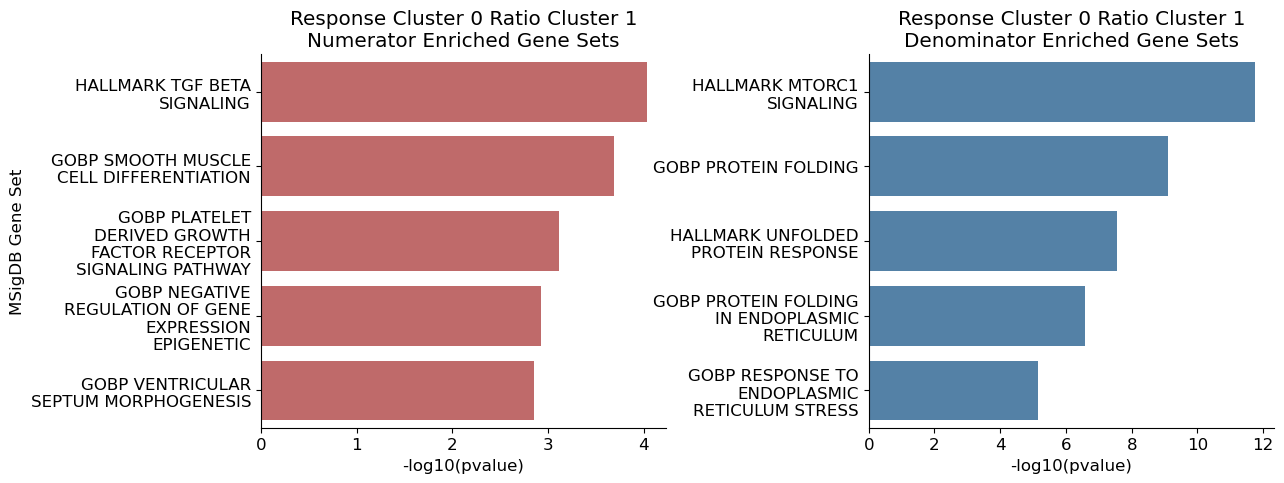

Cluster-1 ratio-cluster-0


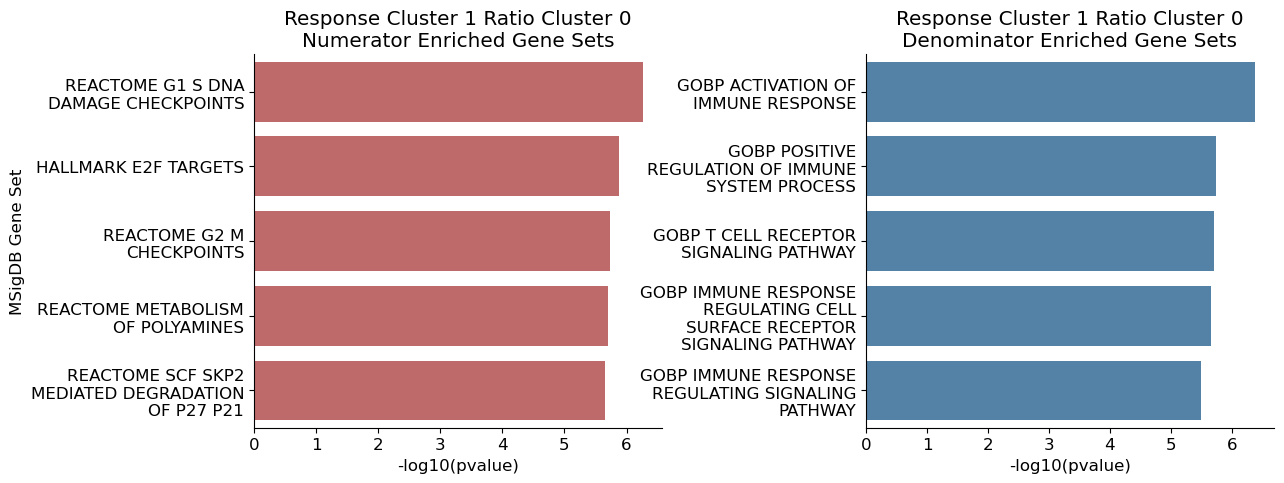

Cluster-1 ratio-cluster-2
Cluster-2 ratio-cluster-0


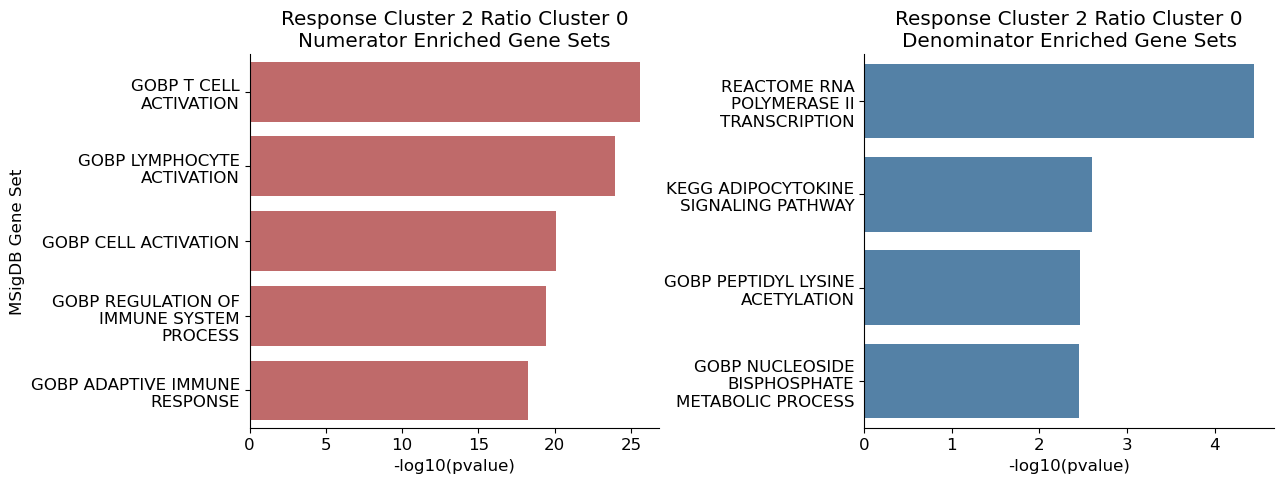

Cluster-2 ratio-cluster-1


In [13]:
import textwrap
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})


for (cluster, ratio_cluster), rows in cluster_plot.groupby(["cluster", "ratio-cluster"]):
    
    print(cluster, ratio_cluster)

    ntmp = cluster_plot[(cluster_plot["cluster"] == cluster) & (cluster_plot["ratio-cluster"] == ratio_cluster) & (cluster_plot['side'] == "numerator")].sort_values("-log10(pvalue)", ascending=False).head(5)
    dtmp = cluster_plot[(cluster_plot["cluster"] == cluster) & (cluster_plot["ratio-cluster"] == ratio_cluster) & (cluster_plot['side'] == "denominator")].sort_values("-log10(pvalue)", ascending=False).head(5)
    
    if len(ntmp) == 0 or len(dtmp) == 0:
        continue
    
    fig, axes = plt.subplots(1, 2, figsize=(13, 5))

    sns.barplot(y="gs", x="-log10(pvalue)", data=ntmp, ax=axes[0], color="indianred")
    sns.barplot(y="gs", x="-log10(pvalue)", data=dtmp, ax=axes[1], color="steelblue")

    axes[0].set_title(f"Response Cluster {cluster[-1]} Ratio Cluster {ratio_cluster[-1]}\nNumerator Enriched Gene Sets")
    axes[1].set_title(f"Response Cluster {cluster[-1]} Ratio Cluster {ratio_cluster[-1]}\nDenominator Enriched Gene Sets")

    axes[0].set_xlabel("-log10(pvalue)")
    axes[1].set_xlabel("-log10(pvalue)")

    axes[0].set_ylabel("MSigDB Gene Set")
    axes[1].set_ylabel("")
    
    for ax in axes:
        labels = []
        for label in ax.get_yticklabels():
            text = label.get_text()
            text = text.split("_")
            text = ' '.join(text)
            labels.append(textwrap.fill(text, 
                                        width=20,
                                        break_long_words=True))
            
        ax.set_yticklabels(labels)    

    plt.tight_layout()

    plt.subplots_adjust(wspace=0.5)
    
    sns.despine()
    
    os.makedirs("../../../../figures/su2c", exist_ok=True)
    plt.savefig(f"../../../../figures/su2c/comparative-{cluster}-{ratio_cluster}-numerator-denominator-gene-set-enrichment-barplot.svg", 
                format='svg', 
                bbox_inches='tight')

    plt.show()

In [14]:
results["Cluster-2"]["ratio-cluster-1"]["denominator"].sort_values("p-value")

,Term,Set size,Overlap ratio,p-value,FDR p-value,Odds ratio,Combined score,Features
30,GOBP_REGULATION_OF_CARDIAC_MUSCLE_CELL_MEMBRAN...,7,0.142857,0.001130,0.061294,1485.960000,10083.271856,FXYD1
44,GOBP_SODIUM_ION_EXPORT_ACROSS_PLASMA_MEMBRANE,16,0.062500,0.002581,0.061294,675.109091,4023.313481,FXYD1
24,GOBP_POSITIVE_REGULATION_OF_SODIUM_ION_TRANSME...,19,0.052632,0.003065,0.061294,571.153846,3305.731383,FXYD1
25,GOBP_POSITIVE_REGULATION_OF_SODIUM_ION_TRANSPORT,32,0.031250,0.005158,0.067687,342.452308,1803.770136,FXYD1
50,KEGG_BASAL_TRANSCRIPTION_FACTORS,35,0.028571,0.005641,0.067687,313.461972,1623.032426,GTF2A1L
54,REACTOME_ION_HOMEOSTASIS,54,0.018519,0.008694,0.069723,203.972477,967.880496,FXYD1
55,REACTOME_ION_TRANSPORT_BY_P_TYPE_ATPASES,55,0.018182,0.008854,0.069723,200.286486,946.725615,FXYD1
38,GOBP_REGULATION_OF_SODIUM_ION_TRANSMEMBRANE_TR...,64,0.015625,0.010298,0.069723,172.255814,788.206806,FXYD1
4,GOBP_EXPORT_ACROSS_PLASMA_MEMBRANE,65,0.015385,0.010458,0.069723,169.616794,773.510568,FXYD1
39,GOBP_REGULATION_OF_SODIUM_ION_TRANSPORT,89,0.011236,0.014302,0.079965,123.972067,526.557256,FXYD1


In [15]:
results["Cluster-2"]["ratio-cluster0"]["numerator"].head(10)

KeyError: 'ratio-cluster0'

In [ ]:
results["Cluster-2"]["ratio-cluster0"]["denominator"].head(10)